In [491]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.datasets import make_regression

## SOFR Averages and Index Data ##
* As an extension of the Secured Overnight Financing Rate (SOFR), the SOFR Averages are compounded averages of the SOFR over rolling 30-, 90-, and 180-calendar day periods.
* The SOFR Index measures the cumulative impact of compounding the SOFR on a unit of investment over time, with the initial value set to 1.00000000 on April 2, 2018, the first value date of the SOFR.
* The SOFR Index value reflects the effect of compounding the SOFR each business day and allows the calculation of compounded SOFR averages over custom time periods.
* Each business day, the New York Fed publishes the SOFR Averages and SOFR Index on the New York Fed's website, shortly after the SOFR is published at approximately 8:00 a.m. ET.

# 1. Daily SOFR #

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Axes: title={'center': 'Daily SOFR'}, xlabel='date'>

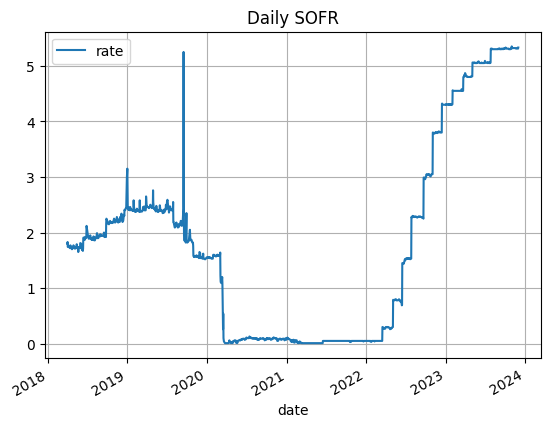

In [492]:
# this is our target?
y_SOFRDAILY = pd.read_excel(f"../data/sofrdaily.xlsx")
y_SOFRDAILY = y_SOFRDAILY.dropna(axis="columns")
y_SOFRDAILY.columns = ["date", "type", "rate", "vol"]
y_SOFRDAILY["date"] = pd.to_datetime(y_SOFRDAILY["date"])
y_SOFRDAILY.set_index("date", inplace=True)
y_SOFRDAILY.drop(columns=["type", "vol"], inplace=True)
y_SOFRDAILY = y_SOFRDAILY.iloc[::-1]
y_SOFRDAILY.plot(grid=True, title="Daily SOFR")

# 2. 3 Month Compounded SOFR #

<Axes: title={'center': '90 day SOFR average'}, xlabel='date'>

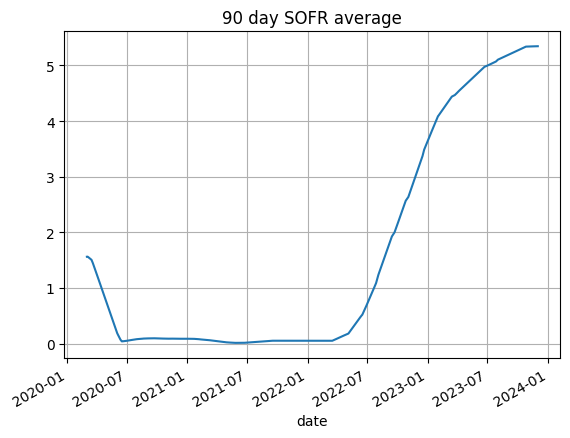

In [493]:
# this is our target?
y_COMP3MSOFR = pd.read_excel(f"../data/sofravg.xlsx")
y_COMP3MSOFR = y_COMP3MSOFR.dropna(axis="columns")
y_COMP3MSOFR.columns = ["date", "type", "30d", "90d", "180d", "idx"]
y_COMP3MSOFR["date"] = pd.to_datetime(y_COMP3MSOFR["date"])
y_COMP3MSOFR = y_COMP3MSOFR.iloc[::-1]
y_COMP3MSOFR.set_index("date", inplace=True)
y_COMP3MSOFR.drop(columns=["type"], inplace=True)
y_COMP3MSOFR["90d"].plot(grid=True, title="90 day SOFR average")

# 3. 3 Month Term CME SOFR - problematic data, need to fix #

            rate_CME3MSOFR
date                      
2019-01-03          2.4328
2019-01-04          2.4296
2019-01-07          2.4276
2019-01-08          2.4298
2019-01-09          2.4390


<Axes: title={'center': 'CME 3 month term SOFR'}, xlabel='date'>

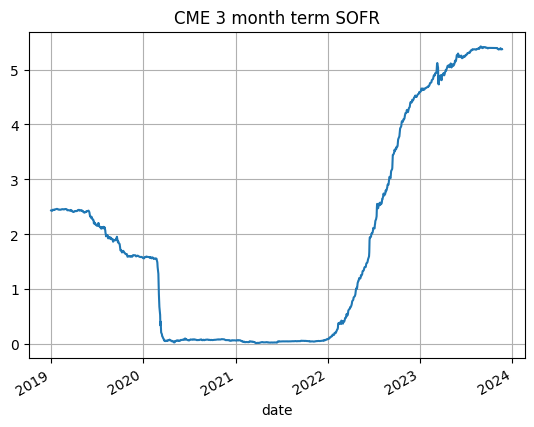

In [494]:
# this is for comparison
x_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
x_CME3MSOFR = x_CME3MSOFR.dropna(axis="columns")
x_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
x_CME3MSOFR["date"] = pd.to_datetime(x_CME3MSOFR["date"])
# flip it so that first row
x_CME3MSOFR = x_CME3MSOFR.iloc[::-1]
x_CME3MSOFR.reset_index(inplace=True)
x_CME3MSOFR = x_CME3MSOFR.drop(columns=["index"])
x_CME3MSOFR.set_index("date", inplace=True)
print(x_CME3MSOFR.head())
x_CME3MSOFR["rate_CME3MSOFR"].plot(grid=True, title="CME 3 month term SOFR")

# 4. 3 Month T-Bill rates #

            rate_USTbill3M
date                      
2018-11-26          2.3775
2018-11-27          2.3771
2018-11-28          2.3704
2018-11-29          2.3616
2018-11-30          2.3654


<Axes: title={'center': 'US T-bill 3month rate'}, xlabel='date'>

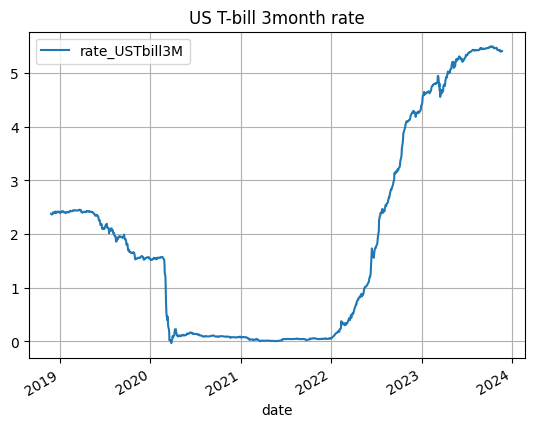

In [495]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
x_USTbill3M.set_index("date", inplace=True)
print(x_USTbill3M.head())
x_USTbill3M.plot(grid=True, title="US T-bill 3month rate")

# 4. 3 Month SOFR Futures #

            price_3MSOFRFuture
date                          
2018-12-14              97.370
2018-12-17              97.405
2018-12-18              97.455
2018-12-19              97.460
2018-12-20              97.470


<Axes: title={'center': '3 month SOFR future price'}, xlabel='date'>

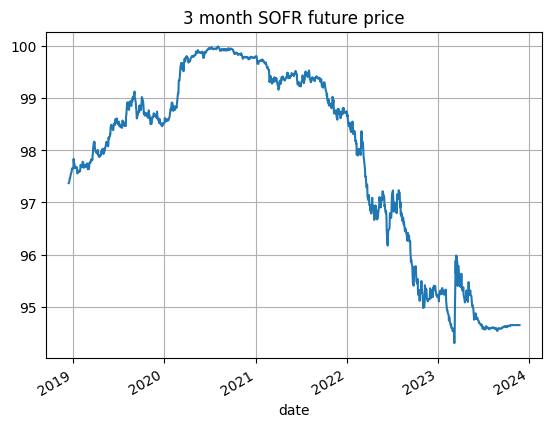

In [496]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
x_3MSOFRFuture.set_index("date", inplace=True)
print(x_3MSOFRFuture.head())
x_3MSOFRFuture["price_3MSOFRFuture"].plot(grid=True, title="3 month SOFR future price")

## Broad General Collateral Rate Data ##
The Broad General Collateral Rate (BGCR) is a measure of rates on overnight Treasury general collateral repurchase agreement (repo) transactions. 

General collateral repo transactions are those for which the specific securities provided as collateral are not identified until after other terms of the trade are agreed. 

The BGCR includes all trades in the Tri-Party General Collateral Rate plus GCF Repo transactions.

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


            rate_bgcr
date                 
2018-04-02       1.77
2018-04-03       1.81
2018-04-04       1.70
2018-04-05       1.70
2018-04-06       1.70


<Axes: title={'center': 'BGCR - daily'}, xlabel='date'>

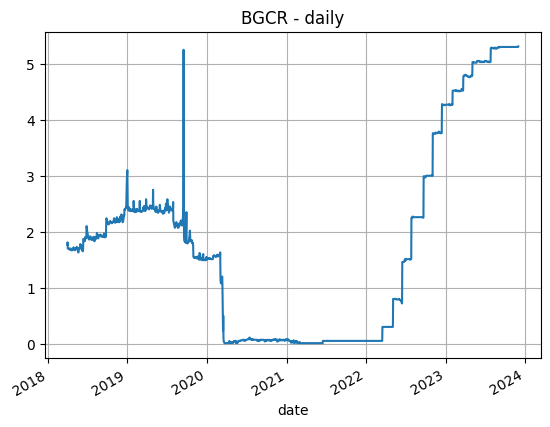

In [497]:
# this is our feature
# bgcr
x_bgcr = pd.read_excel(f"../data/bgcr.xlsx")
x_bgcr = x_bgcr.dropna(axis="columns")
# flip it so that first row
x_bgcr = x_bgcr.iloc[::-1]
x_bgcr.reset_index(inplace=True)
x_bgcr = x_bgcr.drop(columns=["index"])
x_bgcr.columns = ["date", "rate_type", "rate_bgcr", "vol_billion_usd"]
x_bgcr["date"] = pd.to_datetime(x_bgcr["date"])
x_bgcr.drop(columns=["rate_type", "vol_billion_usd"], inplace=True)
x_bgcr.set_index("date", inplace=True)
print(x_bgcr.head())
x_bgcr["rate_bgcr"].plot(grid=True, title="BGCR - daily")

In [498]:
# this is our feature
# vix ?
x_vix = pd.read_csv(f"../data/vix.csv")
# flip it so that first row
x_vix.fillna(method="bfill", inplace=True)
x_vix["Date"] = pd.to_datetime(x_vix["Date"])
x_vix.set_index("Date", inplace=True)
x_vix

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-26,20.780001,20.799999,18.670000,18.900000,18.900000,0.0
2018-11-27,19.410000,19.930000,18.700001,19.020000,19.020000,0.0
2018-11-28,18.870001,19.379999,18.180000,18.490000,18.490000,0.0
2018-11-29,18.650000,20.480000,18.590000,18.790001,18.790001,0.0
2018-11-30,19.180000,19.910000,18.030001,18.070000,18.070000,0.0
...,...,...,...,...,...,...
2023-11-20,14.260000,14.310000,13.390000,13.410000,13.410000,0.0
2023-11-21,13.450000,14.310000,13.130000,13.350000,13.350000,0.0
2023-11-22,13.080000,13.250000,12.820000,12.850000,12.850000,0.0


In [499]:
# this is our feature
# sofrdaily
x_sofrdaily = pd.read_excel(f"../data/sofrdaily.xlsx")
x_sofrdaily = x_sofrdaily.dropna(axis="columns")
# flip it so that first row
x_sofrdaily = x_sofrdaily.iloc[::-1]
x_sofrdaily.reset_index(inplace=True)
x_sofrdaily = x_sofrdaily.drop(columns=["index"])
x_sofrdaily.columns = ["date", "rate_type", "rate_sofrdaily", "vol_billion_usd"]
x_sofrdaily["date"] = pd.to_datetime(x_sofrdaily["date"])
x_sofrdaily.set_index("date", inplace=True)
x_sofrdaily

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,rate_type,rate_sofrdaily,vol_billion_usd
date,,,
2018-04-02,SOFR,1.80,849
2018-04-03,SOFR,1.83,825
2018-04-04,SOFR,1.74,859
2018-04-05,SOFR,1.75,829
2018-04-06,SOFR,1.75,845
...,...,...,...
2023-11-24,SOFR,5.32,1521
2023-11-27,SOFR,5.32,1602
2023-11-28,SOFR,5.32,1593


In [500]:
#
x_fomcrate = pd.read_excel(f"../data/fomc_rate.xlsx")
x_fomcrate.columns = ["date", "incr", "decr", "level"]
x_fomcrate[["hi", "lo"]] = x_fomcrate["level"].str.split("-", expand=True)
x_fomcrate.set_index("date", inplace=True)
fomcrate_dates = x_fomcrate.index
fomcrate_dates

DatetimeIndex(['2023-07-27', '2023-05-04', '2023-03-23', '2023-02-02',
               '2022-12-15', '2022-11-03', '2022-09-22', '2022-07-28',
               '2022-06-16', '2022-05-05', '2022-03-17', '2020-03-16',
               '2020-03-03', '2019-10-31', '2019-09-19', '2019-08-01',
               '2018-12-20', '2018-09-27', '2018-06-14', '2018-03-22'],
              dtype='datetime64[ns]', name='date', freq=None)

In [501]:
fomcrate_dates = [x for x in fomcrate_dates if x > y_COMP3MSOFR.iloc[0]._name]
fomcrate_dates

[Timestamp('2023-07-27 00:00:00'),
 Timestamp('2023-05-04 00:00:00'),
 Timestamp('2023-03-23 00:00:00'),
 Timestamp('2023-02-02 00:00:00'),
 Timestamp('2022-12-15 00:00:00'),
 Timestamp('2022-11-03 00:00:00'),
 Timestamp('2022-09-22 00:00:00'),
 Timestamp('2022-07-28 00:00:00'),
 Timestamp('2022-06-16 00:00:00'),
 Timestamp('2022-05-05 00:00:00'),
 Timestamp('2022-03-17 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-03 00:00:00')]

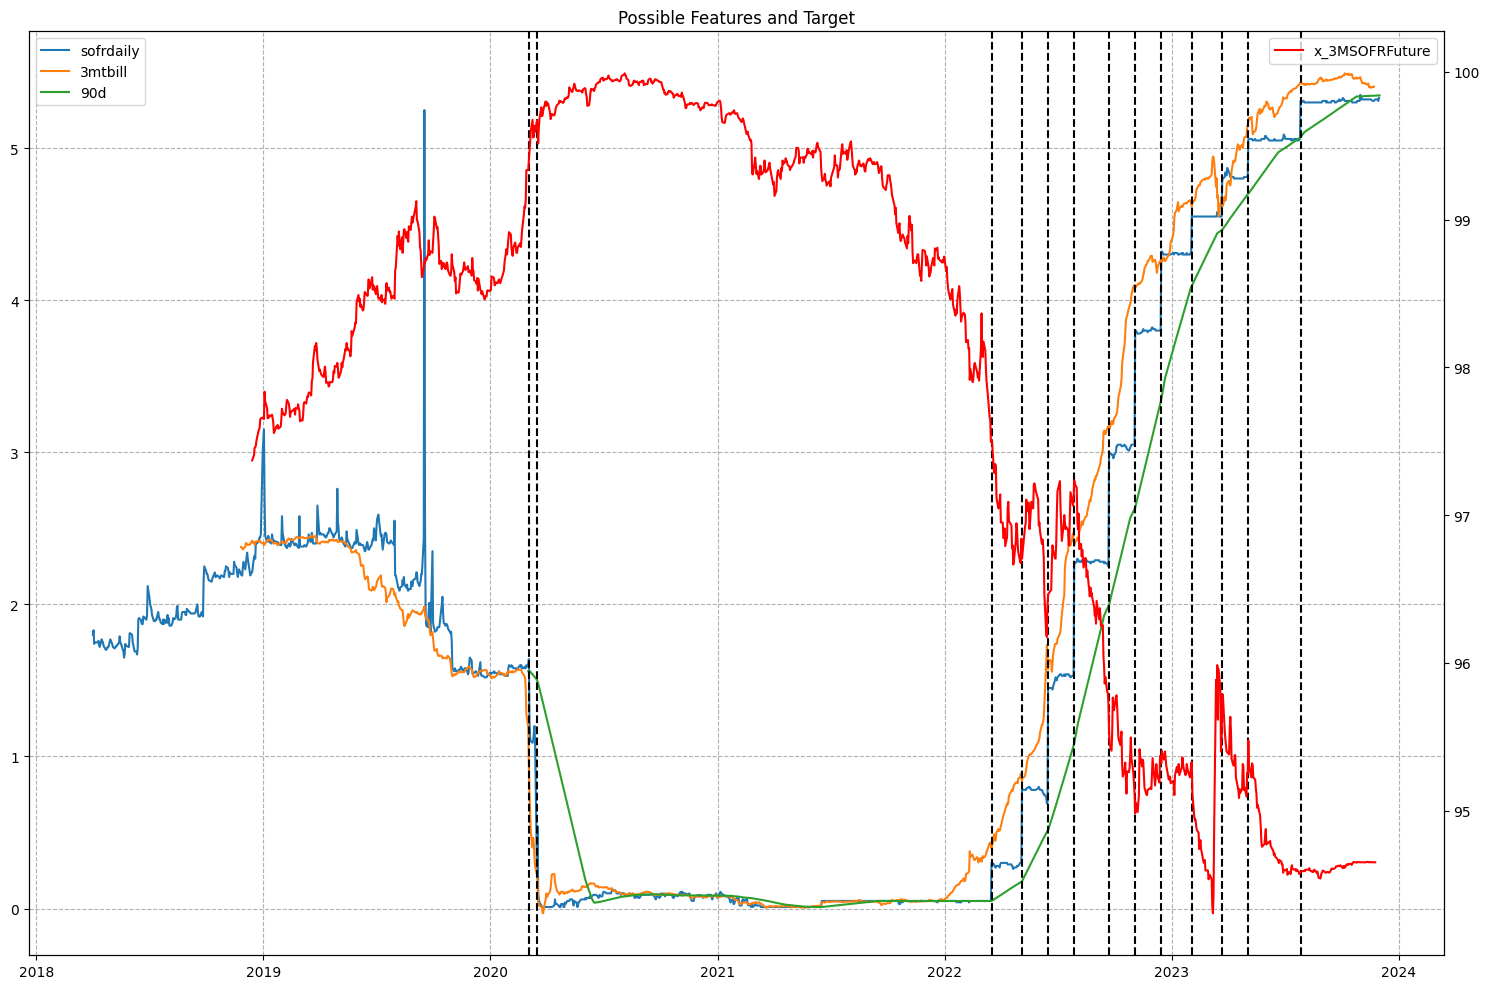

In [502]:
# all together
fig, ax1 = plt.subplots(figsize=(15, 10))
# ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")
# ax1.plot(x_tgcr["rate_tgcr"], label="tgcr")
ax1.plot(x_sofrdaily["rate_sofrdaily"], label="sofrdaily")
ax1.plot(x_USTbill3M["rate_USTbill3M"], label="3mtbill")
# plt.plot(x_3MSOFRFuture["x_price_3MSOFRFuture"], label="3mfut")
ax1.plot(y_COMP3MSOFR["90d"], label="90d")
# THIS IS MISSINGOCTOBER DATA SOMEHOW
# ax1.plot(x_CME3MSOFR["rate_CME3MSOFR"], label="cme3m")
for x in fomcrate_dates:
    ax1.axvline(x=x, linestyle="dashed", color="black")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(x_3MSOFRFuture["price_3MSOFRFuture"], label="x_3MSOFRFuture", color="red")
ax2.legend()
ax1.grid(linestyle="dashed")
plt.title("Possible Features and Target")
plt.tight_layout()
plt.show()

# Data Concatenate to align time period #

In [503]:
# lets give it a shot ?
df = y_SOFRDAILY.copy()
# df.drop(columns=["30d", "180d", "idx"], inplace=True)
df

,rate
date,
2018-04-02,1.80
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
...,...
2023-11-24,5.32
2023-11-27,5.32
2023-11-28,5.32


In [504]:
to_concat = [x_3MSOFRFuture, x_USTbill3M]
for frames in to_concat:
    df = pd.merge(df, frames, on="date", how="left")
    print(df.isna().sum())
print(df.describe())

rate                    0
price_3MSOFRFuture    181
dtype: int64
rate                    0
price_3MSOFRFuture    181
rate_USTbill3M        169
dtype: int64
              rate  price_3MSOFRFuture  rate_USTbill3M
count  1417.000000         1236.000000     1248.000000
mean      1.814086           97.823819        1.866083
std       1.745361            1.833774        1.901367
min       0.010000           94.305000       -0.031200
25%       0.070000           96.361250        0.090275
50%       1.730000           98.515000        1.556850
75%       2.430000           99.380000        2.691925
max       5.350000           99.990000        5.491500


In [505]:
rows_with_na = df[df.isna().any(axis=1)]
rows_with_na

,rate,price_3MSOFRFuture,rate_USTbill3M
date,,,
2018-04-02,1.80,NaN,NaN
2018-04-03,1.83,NaN,NaN
2018-04-04,1.74,NaN,NaN
2018-04-05,1.75,NaN,NaN
2018-04-06,1.75,NaN,NaN
...,...,...,...
2023-11-24,5.32,94.65,NaN
2023-11-27,5.32,NaN,NaN
2023-11-28,5.32,NaN,NaN


In [506]:
df.dropna(inplace=True)
df

,rate,price_3MSOFRFuture,rate_USTbill3M
date,,,
2018-12-14,2.21,97.3700,2.4184
2018-12-17,2.31,97.4050,2.4049
2018-12-18,2.32,97.4550,2.3925
2018-12-19,2.30,97.4600,2.4096
2018-12-20,2.41,97.4700,2.4130
...,...,...,...
2023-11-16,5.32,94.6500,5.3972
2023-11-17,5.32,94.6525,5.3969
2023-11-20,5.31,94.6500,5.4029


In [507]:
df["price_3MSOFRFuture"] = df["price_3MSOFRFuture"].shift(5)
df["rate_USTbill3M"] = df["rate_USTbill3M"].shift(5)
df = df.dropna()

In [508]:
y = df["rate"].copy()
X = df.drop(columns=["rate"]).copy()

In [509]:
X.head()

,price_3MSOFRFuture,rate_USTbill3M
date,,
2018-12-21,97.370,2.4184
2018-12-24,97.405,2.4049
2018-12-26,97.455,2.3925
2018-12-27,97.460,2.4096
2018-12-28,97.470,2.4130


In [510]:
y.head()

date
2018-12-21    2.40
2018-12-24    2.41
2018-12-26    2.44
2018-12-27    2.44
2018-12-28    2.46
Name: rate, dtype: float64

## Mutual Information ##

In [511]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)

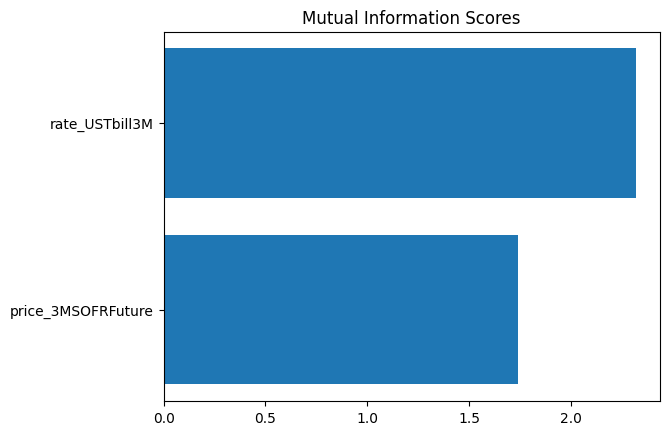

In [512]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100)
plot_mi_scores(mi_scores)

# VIF CHECK #

In [513]:
# Calculate VIF for each predictor variable
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data


# Display the VIF values
vif_results = calculate_vif(X)
print(vif_results)

             Variable       VIF
0  price_3MSOFRFuture  1.880776
1      rate_USTbill3M  1.880776


iseng doang

In [514]:
my_test_size = 300

In [515]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

In [516]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

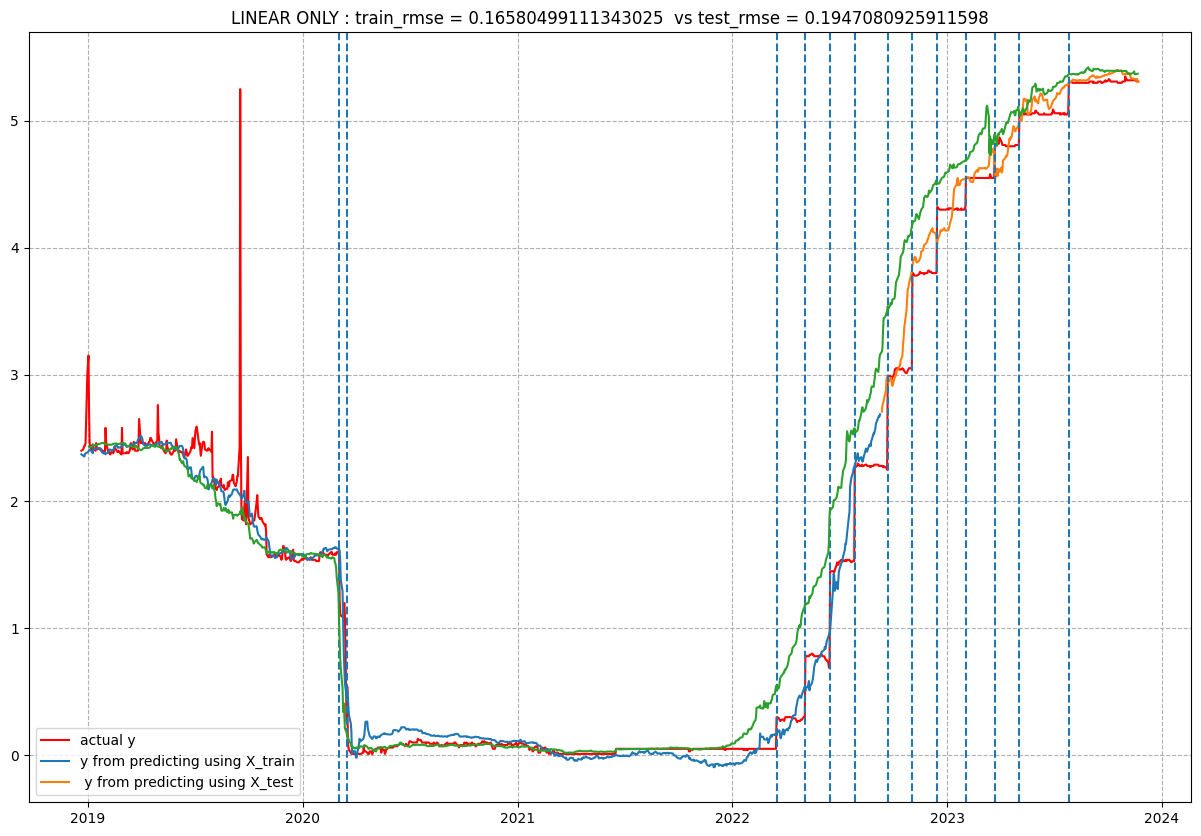

In [517]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="actual y", color="red")
plt.plot(y_fit, label="y from predicting using X_train")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred, label=" y from predicting using X_test")
plt.title(f"LINEAR ONLY : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
for x in fomcrate_dates:
    plt.axvline(x=x, linestyle="dashed")
plt.plot(x_CME3MSOFR["rate_CME3MSOFR"])
plt.grid(linestyle="dashed")
plt.legend()

## xgboost ##

In [518]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

# create target residuals
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb_reg = xgb.XGBRegressor(n_estimators=10000)
xgb_reg.fit(X_train, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: xlabel='date'>

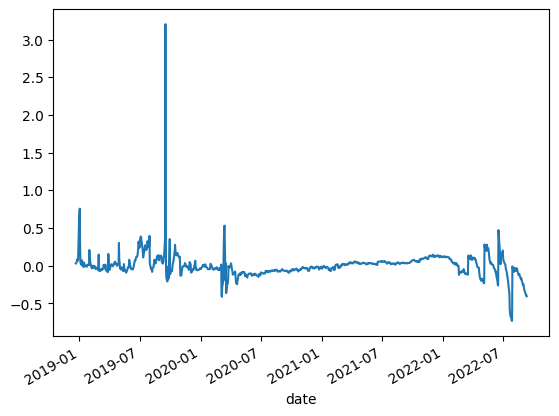

In [519]:
y_resid.plot()

In [520]:
# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb_reg.predict(X_train) + y_fit
y_pred_boosted = xgb_reg.predict(X_test) + y_pred

In [521]:
train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

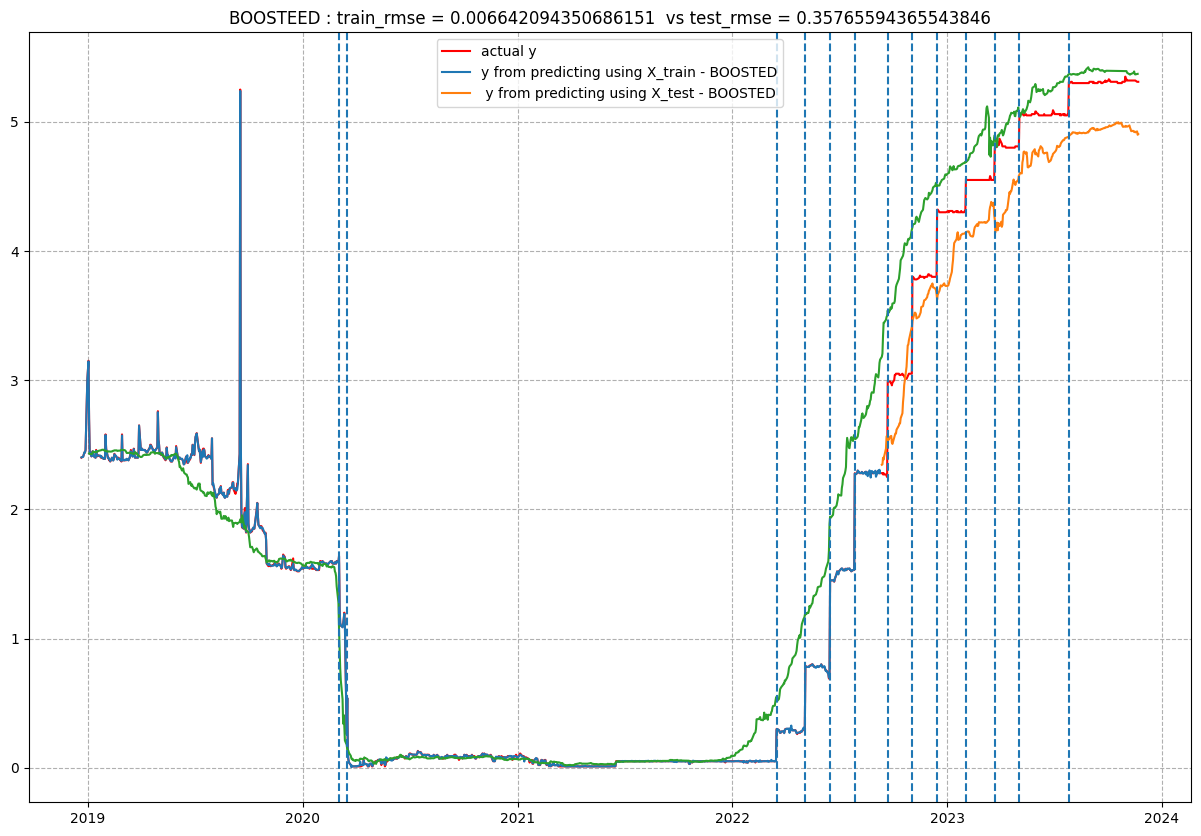

In [522]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="actual y", color="red")
plt.plot(y_fit_boosted, label="y from predicting using X_train - BOOSTED")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred_boosted, label=" y from predicting using X_test - BOOSTED")
plt.title(f"BOOSTEED : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.plot(x_CME3MSOFR["rate_CME3MSOFR"])
for x in fomcrate_dates:
    plt.axvline(x=x, linestyle="dashed")
plt.grid(linestyle="dashed")
plt.legend()